### Download Template

In [ ]:
!wget https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py -O d2l.py

--2022-07-24 00:38:44--  https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59707 (58K) [text/plain]
Saving to: ‘d2l.py’

d2l.py              100%[===================>]  58.31K  --.-KB/s    in 0.007s  

2022-07-24 00:38:45 (8.07 MB/s) - ‘d2l.py’ saved [59707/59707]



The transformer model is solely based on attention mechanisms without any convolutional or recurrent layer.

### Model

<img src="https://classic.d2l.ai/_images/transformer.svg" />

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import d2l

### Positionwise Feed-Forward Networks

In [ ]:
class PositionWiseFFN(tf.keras.layers.Layer):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(*kwargs)
        self.dense1 = tf.keras.layers.Dense(ffn_num_hiddens)
        self.relu = tf.keras.layers.ReLU()
        self.dense2 = tf.keras.layers.Dense(ffn_num_outputs)

    def call(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [ ]:
ffn = PositionWiseFFN(4, 8)
ffn(tf.ones((2, 3, 4)))[0]

<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[ 0.43521643, -0.08296788,  0.3232072 , -0.19611977, -0.30737066,
         0.04654251, -0.04363185, -0.23593184],
       [ 0.43521643, -0.08296788,  0.3232072 , -0.19611977, -0.30737066,
         0.04654251, -0.04363185, -0.23593184],
       [ 0.43521643, -0.08296788,  0.3232072 , -0.19611977, -0.30737066,
         0.04654251, -0.04363185, -0.23593184]], dtype=float32)>

### Residual Connection and Layer Normalization

In [ ]:
ln = tf.keras.layers.LayerNormalization()
bn = tf.keras.layers.BatchNormalization()
X = tf.constant([[1, 2], [2, 3]], dtype=tf.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X, training=True))

layer norm: tf.Tensor(
[[-0.99800605  0.99800605]
 [-0.99800605  0.99800605]], shape=(2, 2), dtype=float32) 
batch norm: tf.Tensor(
[[-0.998006   -0.9980061 ]
 [ 0.9980061   0.99800587]], shape=(2, 2), dtype=float32)


In [ ]:
class AddNorm(tf.keras.layers.Layer):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.ln = tf.keras.layers.LayerNormalization(normalized_shape)

    def call(self, X, Y, **kwargs):
        return self.ln(self.dropout(Y, **kwargs) + X)

In [ ]:
add_norm = AddNorm([1, 2], 0.5) # Normalized_shape is: [i for i in range(len(input.shape))][1:]
add_norm(tf.ones((2, 3, 4)), tf.ones((2, 3, 4)), training=False).shape

TensorShape([2, 3, 4])

### Encoder

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens,
                                                num_heads, dropout, bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def call(self, X, valid_lens, **kwargs):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens, **kwargs), **kwargs)
        return self.addnorm2(Y, self.ffn(Y), **kwargs)

In [ ]:
X = tf.ones((2, 100, 24))
valid_lens = tf.constant([3, 2])
norm_shape = [i for i in range(len(X.shape))][1:]
encoder_blk = EncoderBlock(24, 24, 24, 24, norm_shape, 48, 8, 0.5)
encoder_blk(X, valid_lens, training=False).shape

TensorShape([2, 100, 24])

In [ ]:
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hiddens, num_heads,
                 num_layers, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = [EncoderBlock(
            key_size, query_size, value_size, num_hiddens, norm_shape,
            ffn_num_hiddens, num_heads, dropout, bias) for _ in range(
            num_layers)]

    def call(self, X, valid_lens, **kwargs):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(
            tf.cast(self.num_hiddens, dtype=tf.float32)), **kwargs)
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens, **kwargs)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [ ]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [1, 2], 48, 8, 2, 0.5)
encoder(tf.ones((2, 100)), valid_lens, training=False).shape

TensorShape([2, 100, 24])

### Decoder

In [ ]:
class DecoderBlock(tf.keras.layers.Layer):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super().__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def call(self, X, state, **kwargs):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = tf.concat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if kwargs["training"]:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = tf.repeat(tf.reshape(tf.range(1, num_steps + 1),
                                                 shape=(-1, num_steps)), repeats=batch_size, axis=0)

        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens, **kwargs)
        Y = self.addnorm1(X, X2, **kwargs)
        # Encoder-decoder attention. Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens, **kwargs)
        Z = self.addnorm2(Y, Y2, **kwargs)
        return self.addnorm3(Z, self.ffn(Z), **kwargs), state

In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [1, 2], 48, 8, 0.5, 0)
X = tf.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state, training=False)[0].shape

TensorShape([2, 100, 24])

In [ ]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hidens, num_heads, num_layers, dropout, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = [DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                                  ffn_num_hiddens, num_heads, dropout, i) for i in range(num_layers)]
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def call(self, X, state, **kwargs):
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(tf.cast(self.num_hiddens, dtype=tf.float32)), **kwargs)
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]  # 2 Attention layers in decoder
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state, **kwargs)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

### Training

loss 0.028, 949.7 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7fe6d26cfb40>


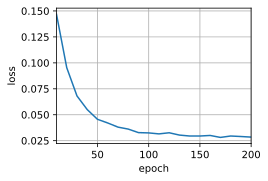

In [ ]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_hiddens, num_heads = 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [2]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens, norm_shape,
    ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens, norm_shape,
    ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => entrez !,  bleu 0.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi <unk> mouillé .,  bleu 0.711


In [ ]:
enc_attention_weights = tf.reshape(
    tf.concat(net.encoder.attention_weights, 0),
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

TensorShape([2, 4, 10, 10])

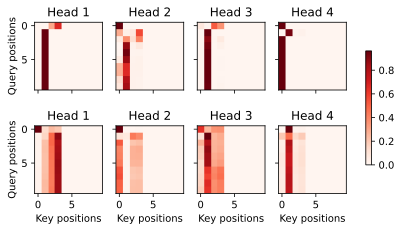

In [ ]:
d2l.show_heatmaps(
    enc_attention_weights, xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

In [ ]:
dec_attention_weights_2d = [head[0] for step in dec_attention_weight_seq
                            for attn in step
                            for blk in attn for head in blk]
dec_attention_weights_filled = tf.convert_to_tensor(
    np.asarray(pd.DataFrame(dec_attention_weights_2d).fillna(
        0.0).values).astype(np.float32))
dec_attention_weights = tf.reshape(dec_attention_weights_filled, shape=(
    -1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = tf.transpose(
    dec_attention_weights, perm=(1, 2, 3, 0, 4))
print(dec_self_attention_weights.shape, dec_inter_attention_weights.shape)

(2, 4, 8, 10) (2, 4, 8, 10)


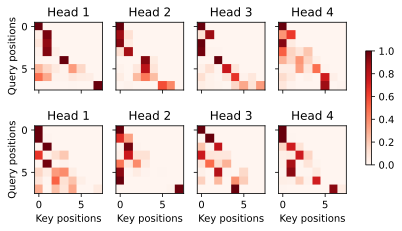

In [ ]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

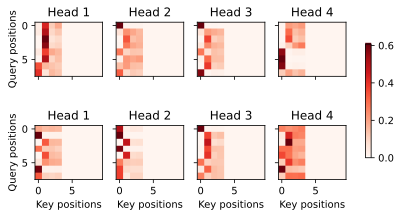

In [ ]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))